# GMM PROJECT 2
*Lukas Elenbergas, 1712238*

Variant: **Car, Cat, Guitar**

***Task***: 
 
The data classes must be picked from [OpenImages V6](https://storage.googleapis.com/openimages/web/index.html) classification task dataset.

In [1]:
# ---------------------------------------------------
# IMPORTS
# ---------------------------------------------------
# Fiftyone package install for the Collab environment
"""!pip install fiftyone"""
import fiftyone as fo
import fiftyone.zoo as foz
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from IPython.display import display, clear_output
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
# ---------------------------------------------------
# ENVIRONMENT VARIABLES
# ---------------------------------------------------
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
MODEL_PATH = 'C:\\Projects\\GMM\Models\\'
IMAGE_PATH = 'C:\\Projects\\GMM\\Images\\'
OTHER_PATH = 'C:\\Projects\\GMM\\Other\\2\\'
NUM_ACCUMULATION_STEPS = 2
# ---------------------------------------------------

In [2]:
# ---------------------------------------------------
# HELPER FUNCTION
# ---------------------------------------------------
def ground_truth_array_generation(labels):
    temporary_array = [0, 0, 0]

    if 'Car' in labels:
        temporary_array[0] = 1
    if 'Cat' in labels:
        temporary_array[1] = 2
    if 'Guitar' in labels:
        temporary_array[2] = 3

    return np.array(temporary_array)
# ---------------------------------------------------

# DATASET

In [3]:
# ---------------------------------------------------
# FIFTYONE DATASET
# ---------------------------------------------------
def create_fo_dataset(
        dataset_name: str,
        dataset_type: str,
        dataset_samp: int,
):
    # Fiftyone dataset creation by loading OpenImages V6 dataset from the FO Zoo collection 
    dataset = foz.load_zoo_dataset(
        'open-images-v6',
        dataset_type,
        label_types='classifications',
        classes=['Car', 'Cat', 'Guitar'],
        only_matching=True,
        max_samples=dataset_samp,
        dataset_name=dataset_name
    )

    # Making the ground truth detection easier to access by appending all lables of the image into one list
    for sample in dataset:
        sample['labels'] = []
        for item in sample.positive_labels.classifications:
            sample['labels'].append(item.label)
        sample['ground_truth'] = ground_truth_array_generation(sample.labels)
        sample.save()

    return dataset
# ---------------------------------------------------

In [4]:
# ---------------------------------------------------
# TORCH DATASET
# ---------------------------------------------------
class ClassificationDataset(Dataset):

    def __init__(self, data, label_field='ground_truth'):
        self.samples = data
        self.label_field = label_field
        self.img_paths = self.samples.values('filepath')
        self.transforms = transforms.Compose([
            transforms.CenterCrop((1024, 1024)),
            transforms.Resize((256, 256), interpolation=F.InterpolationMode.BILINEAR, antialias=True),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        image = Image.open(img_path).convert('RGB')
        ground_truth = torch.Tensor(sample[self.label_field])
        image_tensor = self.transforms(image)

        return { 'image': image_tensor, 'ground_truth': ground_truth}
    
    def __len__(self):
        return len(self.img_paths)

    def sample_path(self, idx):
        return self.img_paths[idx]
# ---------------------------------------------------

# MODEL
Based on the VGG from scratch tutorial here: https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [5]:
# ---------------------------------------------------
# VGG MODEL
# ---------------------------------------------------
class VGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32768 , 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
# ---------------------------------------------------

# TRAINING

In [6]:
# ---------------------------------------------------
# PLOT DRAWING METHOD
# ---------------------------------------------------
def live_plot(loss_ax, loss_fig, loss_arr, avg_loss_arr, val_loss_arr, loss_x):
    x_axis = [i for i in range(len(loss_arr))]                         

    # Drawing the training loss graph
    loss_ax.cla()
    loss_ax.set_ylim(0, 2)
    loss_ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    loss_ax.set_ylabel('Loss')
    loss_ax.set_xlabel('Training Iteration')
    clear_output(wait=True)
    
    # Loss printing after every cycle is left out for this task
    # loss_ax.plot(x_axis, loss_arr, color='Blue', alpha=0.2, label='Loss Over Time')

    # Drawing average epoch loss
    loss_ax.plot(loss_x, avg_loss_arr, color='Blue', label='Average Epoch Loss')
    
    # Plotting validation loss
    loss_ax.plot(loss_x, val_loss_arr, color='Green', label='Validation Loss')

    loss_ax.legend(loc='upper right')
    display(loss_fig)
# ---------------------------------------------------

In [7]:
# ---------------------------------------------------
# MAIN TRAINING METHOD
# ---------------------------------------------------
def train_model(
    model,
    device,
    train_dataset,
    validation_dataset,
    epochs: int = 40,  # Ideally 80
    batch_size: int = 4,
    learning_rate: float = 1e-5,
    gradient_clipping: float = 1.0
):
  # 1. Variables for loss graph tracking
  loss_arr = []
  avg_loss_arr = []
  val_loss_arr = []
  loss_x = []
  loss_fig = plt.figure()
  loss_ax = loss_fig.add_subplot(1, 1, 1)

  # 2. Creating training and validation data loaders
  loader_args = dict(batch_size=batch_size, pin_memory=True)
  train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
  val_loader = DataLoader(validation_dataset, shuffle=True, drop_last=True, **loader_args)
  
  # 3. Set up optimizer and loss function
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
  loss_function = nn.CrossEntropyLoss()

  # 4. Begining of training
  for epoch in range(epochs):

    """ TRAINING ROUND """
    model.train()
    # Variables for loss plotting and gradient accumulation
    total_epoch_loss = 0
    total_epoch_loss_count = 0
    accumulation_loss = 0
    for batch_idx, batch in enumerate(train_loader):
      # Generating model output
      images, ground_truth = batch['image'].to(device), batch['ground_truth'].to(device)
      outputs = model(images)
      
      # Loss calculation
      loss = loss_function(outputs, ground_truth.squeeze(1))
      loss = loss / NUM_ACCUMULATION_STEPS
      accumulation_loss += loss
      # Cleanup to reduce memory consumption
      del loss
      del outputs

      # Backpropagation and parameter update
      if (batch_idx + 1) % NUM_ACCUMULATION_STEPS == 0:
        optimizer.zero_grad()
        accumulation_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        # Loss array update and dditional preparation for loss plotting
        loss_arr_item = accumulation_loss.to(torch.device('cpu'))
        loss_arr.append(loss_arr_item.item())
        total_epoch_loss += accumulation_loss
        total_epoch_loss_count += 1
        accumulation_loss = 0
    # More loss plotting prep
    loss_x.append(len(loss_arr))
    current_avg_loss = total_epoch_loss / total_epoch_loss_count
    current_avg_loss = current_avg_loss.to(torch.device('cpu'))
    avg_loss_arr.append(current_avg_loss.item())

    """ VALIDATION ROUND """
    model.eval()
    # Variables for validation loss plotting
    val_loss_count = 0
    val_loss_sum = 0
    for val_batch in val_loader:
      val_images, val_ground_truth = val_batch['image'].to(device), val_batch['ground_truth'].to(device)
      val_outputs = model(val_images)
      with torch.no_grad():
        val_loss = loss_function(val_outputs, val_ground_truth.squeeze(1))
      val_loss_sum += val_loss
      val_loss_count += 1
      # Cleanup to reduce memory consumption
      del val_loss
      del val_outputs

    # Validation loss plotting prep
    current_val_loss = val_loss_sum / val_loss_count
    val_loss_arr_item = current_val_loss.to(torch.device('cpu'))
    val_loss_arr.append(val_loss_arr_item.item())

    # Learning rate adjustment handling
    scheduler.step(val_loss_arr_item)

    # Training and validation loss plotting
    live_plot(loss_ax, loss_fig, loss_arr, avg_loss_arr, val_loss_arr, loss_x)

  return loss_arr, val_loss_arr, loss_x
# ---------------------------------------------------

In [8]:
# ---------------------------------------------------
# PREP BEFORE TRAINING
# ---------------------------------------------------
# DEVICE INIT
# ---------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')
# ---------------------------------------------------
# MODEL INIT
# ---------------------------------------------------
model = VGG16()
model = model.to(memory_format=torch.channels_last)
model.to(device=device)
# ---------------------------------------------------
# DATASET SPLIT
# ---------------------------------------------------
dataset_size = 8000
split_ratio = 0.2
validation_split = test_split = int(dataset_size * split_ratio)
train_split = dataset_size - (validation_split + test_split)
# ---------------------------------------------------
# DATASET INIT (VIA CREATION OR LOADING)
# ---------------------------------------------------
if 'Training_2' and 'Validation_2' not in fo.list_datasets():
    what_do = 0
else:
    what_do = 1
match what_do:
    case 0:  # CREATING THE TRAINING & VALIDATION DATASETS AFTER DELETING ANY OLDER ONES
        train_dataset = ClassificationDataset(create_fo_dataset('Training_2', 'train', train_split))
        validation_dataset = ClassificationDataset(create_fo_dataset('Validation_2', 'validation', validation_split))
    case 1:  # LOADING THE TRAINING & VALIDATION DATASETS
        train_dataset = ClassificationDataset(fo.load_dataset('Training_2'))
        validation_dataset = ClassificationDataset(fo.load_dataset('Validation_2'))
# ---------------------------------------------------

Using device cuda


In [9]:
# ---------------------------------------------------
# TRAINING INIT
# ---------------------------------------------------
train = False

if train:
    final_loss, final_val_loss, loss_x = train_model(
        model=model, 
        device=device,
        train_dataset=train_dataset, 
        validation_dataset=validation_dataset,
        )
# ---------------------------------------------------

# EVERYTHING ELSE

In [10]:
# ---------------------------------------------------
# MODEL AND LOSS DATA MANAGEMENT
# ---------------------------------------------------
do_what = 1
model_name = '2_model_final'

match do_what:
    case 0:  # SAVE MODEL AND RELATED DATA
        torch.save(model.state_dict(), MODEL_PATH + model_name)
        np.save(model_name + '_final_loss.npy', final_loss)
        np.save(model_name + '_final_val_loss.npy', final_val_loss)
        np.save(model_name + '_loss_x.npy', loss_x)
    case 1:  # LOAD MODEL AND RELATED DDATA
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = VGG16()
        model = model.to(memory_format=torch.channels_last)
        model.load_state_dict(torch.load(MODEL_PATH + model_name))
        model.to(device=device)
        final_loss = np.load(OTHER_PATH + model_name + '_final_loss.npy')
        final_val_loss = np.load(OTHER_PATH + model_name + '_final_val_loss.npy')
        loss_x = np.load(OTHER_PATH + model_name + '_loss_x.npy')
# ---------------------------------------------------

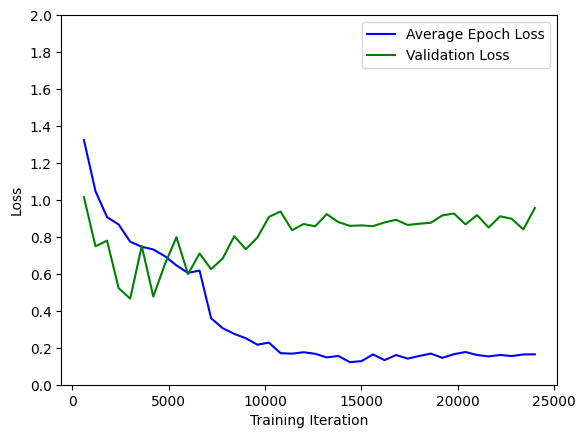

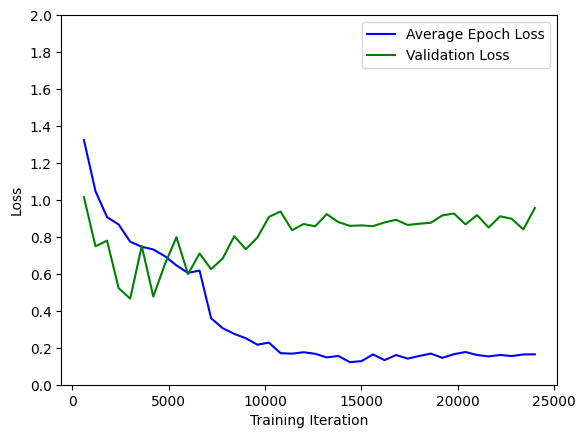

In [11]:
# ---------------------------------------------------
# REDISPLAY LOSS GRAPH
# ---------------------------------------------------
loss_fig = plt.figure()
loss_ax = loss_fig.add_subplot(1, 1, 1)

elements_per_epoch = int(train_split / 8)
avg_loss_arr = []

for i in range(0, len(final_loss), elements_per_epoch):
    chunk = final_loss[i:i+elements_per_epoch]
    average = sum(chunk) / elements_per_epoch
    avg_loss_arr.append(average)

live_plot(loss_ax, loss_fig, final_loss, avg_loss_arr, final_val_loss, loss_x)
# ---------------------------------------------------

In [12]:
# ---------------------------------------------------
# TESTING DATASET INIT
# ---------------------------------------------------
if 'Testing_2' in fo.list_datasets():
    fo_dataset = fo.load_dataset('Testing_2')
else:
    fo_dataset = create_fo_dataset('Testing_2', 'test', test_split)
testing_dataset = ClassificationDataset(fo_dataset)
# ---------------------------------------------------
# TRANSFORMATIONS FOR IMAGES
# ---------------------------------------------------
all_transforms = transforms.Compose([
    transforms.CenterCrop((1024, 1024)),
    transforms.Resize((256, 256), interpolation=F.InterpolationMode.BILINEAR, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# ---------------------------------------------------
# LIST WITH ALL OF THE CLASSES
# ---------------------------------------------------
all_labels = ['Car', 'Cat', 'Guitar']
# ---------------------------------------------------
# ---------------------------------------------------
# FUNCTION TO RETURN INDICES OF PREDICTED CLASSES
# ---------------------------------------------------
def get_indices(thresholded_output):
    number_of_classes = thresholded_output.count_nonzero()
    _, predicted_classes = torch.topk(thresholded_output, number_of_classes)
    predicted_classes = predicted_classes.cpu().numpy().squeeze()

    return predicted_classes
# ---------------------------------------------------
# FUNCTION TO RETURN THE READABLE LABELS
# ---------------------------------------------------
def readable_predictions(predicted_classes):
    predicted_labels = []
    match predicted_classes.size:
        case 0:
            predicted_labels.append("none")
        case 1:
            predicted_labels.append(all_labels[predicted_classes])
        case _ if predicted_classes.size > 1:
            for item in predicted_classes:
                predicted_labels.append(all_labels[item])
    return predicted_labels
# ---------------------------------------------------

In [13]:
# ---------------------------------------------------
# THRESHOLD AND METRICS
# ---------------------------------------------------
threshold = 0.5
TP = 0
TN = 0
FP = 0
FN = 0
# ---------------------------------------------------
# CALCULATING STATS
# ---------------------------------------------------
model.eval()
for data_item in testing_dataset:
    # Getting the output tensor from the model and thresholding it
    input_image = data_item['image'].unsqueeze(0).to(device)
    output = model(input_image)
    output = torch.softmax(output, dim=1)
    thresholded_output = (output >= threshold).int()
    # Getting the indices of predicted classes
    predicted_classes = get_indices(thresholded_output)
    # Getting the actual labels of predicted classes
    predicted_labels = readable_predictions(predicted_classes)
    # Formatting the labels into an array comparable to the ground truth
    predicted_ground_truth = ground_truth_array_generation(predicted_labels)
    predicted_ground_truth = np.array([1 if x > 0 else x for x in predicted_ground_truth])
    ground_truth = data_item['ground_truth'].int().numpy()
    ground_truth = np.array([1 if x > 0 else x for x in ground_truth])
    # print(ground_truth, predicted_ground_truth)
    # Calculating TP, TN, FP, FN
    TP += np.sum(np.bitwise_and(ground_truth == 1, predicted_ground_truth == 1))
    TN += np.sum(np.bitwise_and(ground_truth == 0, predicted_ground_truth == 0))
    FP += np.sum(np.bitwise_and(ground_truth == 0, predicted_ground_truth == 1))
    FN += np.sum(np.bitwise_and(ground_truth == 1, predicted_ground_truth == 0))

metrics = {}
metrics['accuracy'] = (TP + TN) / (TP + FP + TN + FN)
metrics['recall'] = TP / (TP + FN)
metrics['precision'] = TP / (TP + FP)
metrics['F1'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])

confusion_matrix = {}
confusion_matrix['TP'] = TP
confusion_matrix['FP'] = FP
confusion_matrix['FN'] = FN
confusion_matrix['TN'] = TN

print(metrics)
print("Confusion matrix: ", confusion_matrix)
# ---------------------------------------------------

{'accuracy': 0.930625, 'recall': 0.8940149625935162, 'precision': 0.8979336255479023, 'F1': 0.8959700093720713}
Confusion matrix:  {'TP': 1434, 'FP': 163, 'FN': 170, 'TN': 3033}


In [14]:
# ---------------------------------------------------
# IMAGE PREP BEFORE PASSING TO MODEL
# ---------------------------------------------------
image = Image.open(IMAGE_PATH + '4.jpg')
image = all_transforms(image).unsqueeze(0).to(device)
# ---------------------------------------------------
# LOCAL THRESHOLD
# ---------------------------------------------------
local_threshold = 0.5
# ---------------------------------------------------
# PREDICTING THE CLASS USING THE PRETRAINED MODEL
# ---------------------------------------------------
output = model(image)
output = torch.softmax(output, dim=1)
thresholded_output = (output > local_threshold).int()
predicted_classes = get_indices(thresholded_output)
predicted_labels = readable_predictions(predicted_classes)
print(predicted_labels)
# --------------------------------------------------

['Cat']
